**STEP 1: Import Libraries**

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**STEP 2: Load & Inspect Dataset**

In [ ]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/test.csv')

df.head()

,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Subject  2191 non-null   object
 1   body     2191 non-null   object
 2   date     2191 non-null   object
 3   from     2191 non-null   object
dtypes: object(4)
memory usage: 68.6+ KB


In [ ]:
df.isnull().sum()

,0
Subject,0
body,0
date,0
from,0


**STEP 3: Column Mapping**

In [ ]:
df['employee_id'] = df['from']
df['text'] = (
    df['Subject'].fillna('') + " " + df['body'].fillna('')
).str.lower().str.strip()

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

In [ ]:
df.head()

,Subject,body,date,from,employee_id,text
0,ERCOT Readiness Update attached,We at TradersNews are gearing up to launch our...,2010-01-01,johnny.palmer@enron.com,johnny.palmer@enron.com,ercot readiness update attached we at tradersn...
1,RE: data,Well have to go to Vegas I guess??\n\n\n,2010-01-02,eric.bass@enron.com,eric.bass@enron.com,re: data well have to go to vegas i guess??
2,Re: Wellhead Accrual Income,"Melissa,\n\nHere are the accrual values for Q1...",2010-01-02,lydia.delgado@enron.com,lydia.delgado@enron.com,"re: wellhead accrual income melissa,\n\nhere a..."
3,(No Subject),Attached are two of TradersNews Energy's three...,2010-01-02,don.baughman@enron.com,don.baughman@enron.com,(no subject) attached are two of tradersnews e...
4,Tiger recruiting #1,"Sorry, but this is funny . . .\nhttp://auburn....",2010-01-02,lydia.delgado@enron.com,lydia.delgado@enron.com,"tiger recruiting #1 sorry, but this is funny ...."


**STEP 4: Sentiment Labeling**

In [ ]:
sid = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = sid.polarity_scores(text)['compound']
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df['sentiment'] = df['text'].apply(get_sentiment)

In [ ]:
df[['text', 'sentiment']].head()

,text,sentiment
0,ercot readiness update attached we at tradersn...,Positive
1,re: data well have to go to vegas i guess??,Positive
2,"re: wellhead accrual income melissa,\n\nhere a...",Positive
3,(no subject) attached are two of tradersnews e...,Positive
4,"tiger recruiting #1 sorry, but this is funny ....",Positive


**STEP 5: Exploratory Data Analysis**

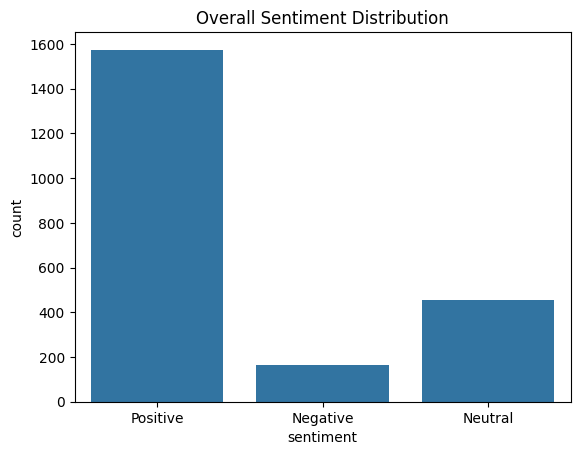

In [ ]:
sns.countplot(data=df, x='sentiment')
plt.title("Overall Sentiment Distribution")
plt.show()

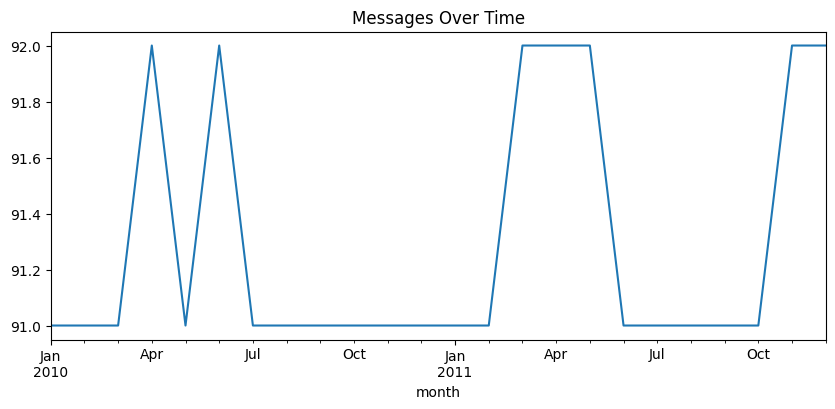

In [ ]:
df['month'] = df['date'].dt.to_period('M')

df.groupby('month').size().plot(kind='line', figsize=(10,4))
plt.title("Messages Over Time")
plt.show()

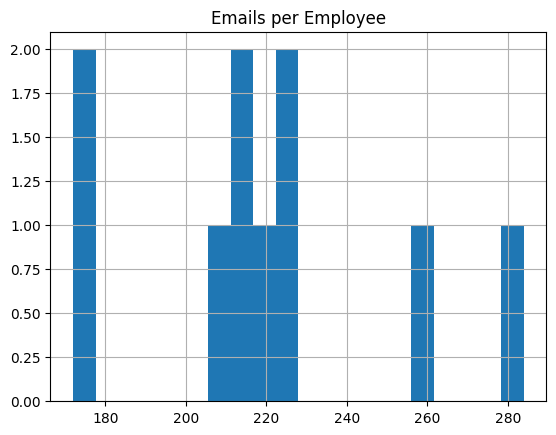

In [ ]:
df['employee_id'].value_counts().hist(bins=20)
plt.title("Emails per Employee")
plt.show()

**STEP 6: Monthly Sentiment Score**

In [ ]:
score_map = {"Positive": 1, "Neutral": 0, "Negative": -1}
df['sentiment_score'] = df['sentiment'].map(score_map)

monthly_scores = (
    df.groupby(['employee_id', 'month'])['sentiment_score']
    .sum()
    .reset_index()
)

In [ ]:
monthly_scores.head()

,employee_id,month,sentiment_score
0,bobette.riner@ipgdirect.com,2010-01,1
1,bobette.riner@ipgdirect.com,2010-02,8
2,bobette.riner@ipgdirect.com,2010-03,4
3,bobette.riner@ipgdirect.com,2010-04,3
4,bobette.riner@ipgdirect.com,2010-05,3


**STEP 7: Employee Ranking**

In [ ]:
def rank_employees(df, positive=True):
    return (
        df.sort_values(
            by=['sentiment_score', 'employee_id'],
            ascending=[not positive, True]
        )
        .groupby('month')
        .head(3)
    )

top_positive = rank_employees(monthly_scores, positive=True)
top_negative = rank_employees(monthly_scores, positive=False)

In [ ]:
display(top_positive)

,employee_id,month,sentiment_score
160,lydia.delgado@enron.com,2011-05,20
28,don.baughman@enron.com,2010-05,16
54,eric.bass@enron.com,2010-07,16
65,eric.bass@enron.com,2011-06,16
83,john.arnold@enron.com,2010-12,16
...,...,...,...
79,john.arnold@enron.com,2010-08,7
172,patti.thompson@enron.com,2010-05,7
220,sally.beck@enron.com,2010-05,7
50,eric.bass@enron.com,2010-03,6


In [ ]:
display(top_negative)

,employee_id,month,sentiment_score
61,eric.bass@enron.com,2011-02,-1
137,kayne.coulter@enron.com,2011-06,-1
162,lydia.delgado@enron.com,2011-07,-1
21,bobette.riner@ipgdirect.com,2011-10,0
37,don.baughman@enron.com,2011-02,0
...,...,...,...
130,kayne.coulter@enron.com,2010-11,4
152,lydia.delgado@enron.com,2010-09,4
166,lydia.delgado@enron.com,2011-11,4
34,don.baughman@enron.com,2010-11,5


**STEP 8: Flight Risk Identification**

In [ ]:
negative_df = df[df['sentiment'] == 'Negative']
flight_risk_employees = []

for emp, emp_df in negative_df.groupby('employee_id'):
    emp_df = emp_df.sort_values('date')
    for i in range(len(emp_df)):
        start = emp_df.iloc[i]['date']
        end = start + timedelta(days=30)
        count = emp_df[
            (emp_df['date'] >= start) &
            (emp_df['date'] <= end)
        ].shape[0]
        if count >= 4:
            flight_risk_employees.append(emp)
            break

flight_risk_employees = list(set(flight_risk_employees))

In [ ]:
display(flight_risk_employees)

['johnny.palmer@enron.com',
 'patti.thompson@enron.com',
 'eric.bass@enron.com',
 'sally.beck@enron.com',
 'bobette.riner@ipgdirect.com']

**STEP 9: Feature Engineering**

In [ ]:
df['message_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

monthly_features = df.groupby(['employee_id', 'month']).agg({
    'sentiment_score': 'sum',
    'message_length': 'mean',
    'word_count': 'mean',
    'text': 'count'
}).reset_index()

monthly_features.rename(columns={'text': 'message_count'}, inplace=True)

**STEP 10: Linear Regression Modeling**

In [ ]:
X = monthly_features[['message_count', 'message_length', 'word_count']]
y = monthly_features['sentiment_score']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [ ]:
print("MAE:", mean_absolute_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
print("RMSE:", np.sqrt(mse))
print("R2:", r2_score(y_test, y_pred))

MAE: 1.4337823652481856
RMSE: 1.836019376396763
R2: 0.7130667831106088
